### Seeing that our between-participant attempts did not do a great job,
#### Can we predict recall WITHIN participants?

In [8]:
import numpy as np # scientific computing 
import scipy.io
from scipy import stats 
import pandas as pd # data manipulation 
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import brainiak.funcalign.srm
from brainiak import image, io
import matplotlib.pyplot as plt
%matplotlib inline 
import time

# useful variables
nScenes = 50
nScenes1 = 27
nTRs1 = 946 
nScenes2 = 23
nTRs2 = 1030
n = 17

# for each participant (of 17), let's get the recall data for each of 50 scenes
# recalled (1/0), quality (0 if not recalled, else 1-5, 5), recall time len
recall_dfs = []
recall_path = "SherlockData/recall_transcripts/"
for pid in range(1, 18):
    filename = "NN_S" + str(pid) + "_Scene_Matches_edit4matlab.xlsx"
    file = pd.read_excel(recall_path + filename)
    file = file.replace(np.nan, -1, regex=True)
    quality = []
    recalled = []
    duration = []
    for s in range(50):
        if file['quality'][s] == -1: # did not recall
            quality.append(0)
            recalled.append(0)
            duration.append(0)
        else:
            quality.append(file['quality'][s])
            recalled.append(1)
            duration.append(file['end time sec'][s] - file['start time sec'][s])
    recall_dfs.append(np.transpose([recalled, quality, duration]))
recall_dfs = np.array(recall_dfs)

# Load in the brain data: 17 participants, 26k WB mask voxels, 1976 TRs
movie_data = []
for pid in range(1, 18):
    moviedat = np.load("SherlockData/movie_masked/movie_wb_S" + str(pid) + ".npz")['data']
    # stored as TR x voxel, but we want voxel x TR data 
    movie_data.append(np.transpose(moviedat))
movie_data = np.array(movie_data)

movieTRs = np.array(pd.read_csv("movieTRs.csv", index_col = 0))

# zscores a list of 2D arrays, by row
def zscore(data):
    for pid in range(len(data)):
        data[pid] = np.nan_to_num(stats.zscore(data[pid], axis = 1, ddof = 1))
    return np.array(data)

# Loading in data describing movie features 
features = pd.read_csv("features.csv", index_col = 0) 

# Downsampling function (features x TRs -> features x SCENES)
# given data matrix of 1 participant (features x TRs)
# returns a features x SCENEs matrix, where 
# corresponding TRs in a scene are averaged 
def scene_voxelavg(dat_tr, startind = 0, endind = nScenes):
    dat_sc = []
    for sceneidx in range(startind, endind):
        startTR = movieTRs[sceneidx, 1] - 1 
        endTR = movieTRs[sceneidx, 2] - 1
        response_avg = np.reshape(np.mean(dat_tr[:,startTR:endTR + 1], axis = 1), (-1, 1))
        if len(dat_sc) == 0:
            dat_sc = response_avg
        else:
            dat_sc = np.append(dat_sc, response_avg, axis = 1)
    return np.array(dat_sc)

In [9]:
movie_data_sc = [scene_voxelavg(movie_data[i]) for i in range(n)] # get features x SCENES matrices 
recalled = recall_dfs[:, :, 0] # 17 x 50 of whether participants recalled each scene 

In [10]:
# for a single participant, predict the recall for each scene using LOOCV on the others 
# given an X matrix of feature x time (each time is a single observation)
def predSbjRecall(X, y, classifier = svm.SVC(kernel = "linear")):
    preds = []
    for scene in range(len(y)): # LOOCV
        train_idx = [i for i in range(len(y)) if i != scene]
        test_idx = [scene]
        
        trainx = X[:, train_idx].T
        testx = X[:, test_idx].T
        trainy = y[train_idx]
        testy = y[test_idx]
        
        classifier.fit(trainx, trainy)
        pred = classifier.predict(testx)
        preds.append(pred[0])
    return preds    

In [11]:
# We can also try to predict recall by TRs

# given a participant index and
# recalltype (0 for nRecall, 1 for time of recall, 2 for quality of recall)
# returns a nTRs-len vector representation for recall from start scene index
def get_recall_labels(pidx, startind = 0, recalltype = 0, endind = nScenes):
    labels_byTR = []
    startTR = movieTRs[startind, 1] - 1 
    for sceneidx in range(startind, endind):
        endTR = movieTRs[sceneidx, 2] - 1 
        labels_byTR = np.append(labels_byTR, 
            np.repeat(recall_dfs[pidx, sceneidx, recalltype], endTR-startTR+1))
        startTR = endTR + 1
    return np.array(labels_byTR)

In [12]:
srm = brainiak.funcalign.srm.SRM(n_iter = 10, features = 50)
srm.fit(movie_data)
shared_data = srm.transform(movie_data)

In [13]:
shared_data_sc = [scene_voxelavg(shared_data[i]) for i in range(n)] # get features x SCENES matrices 

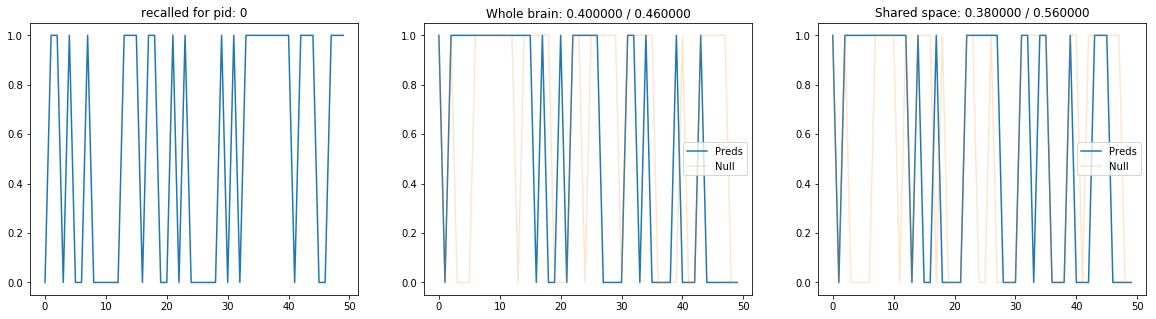

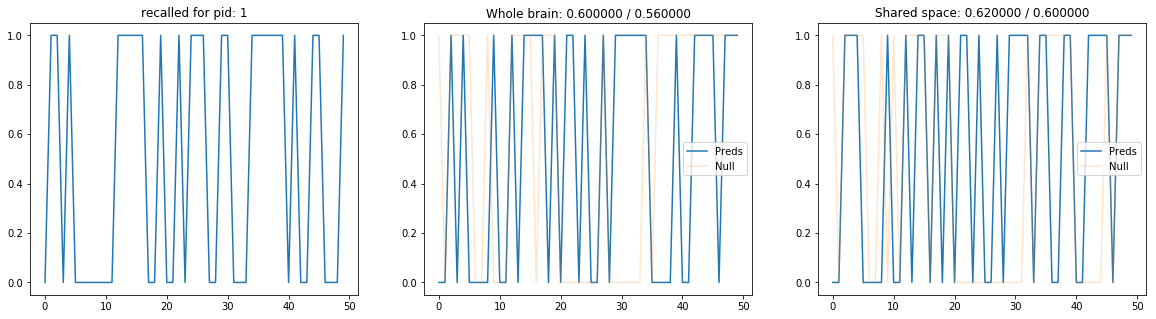

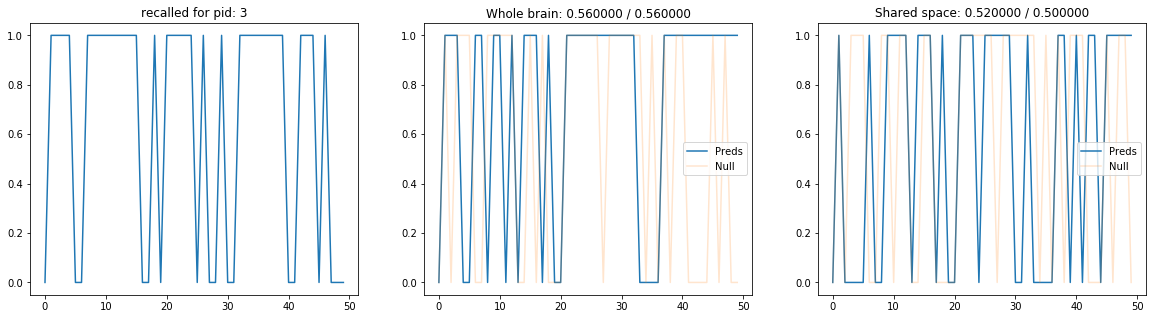

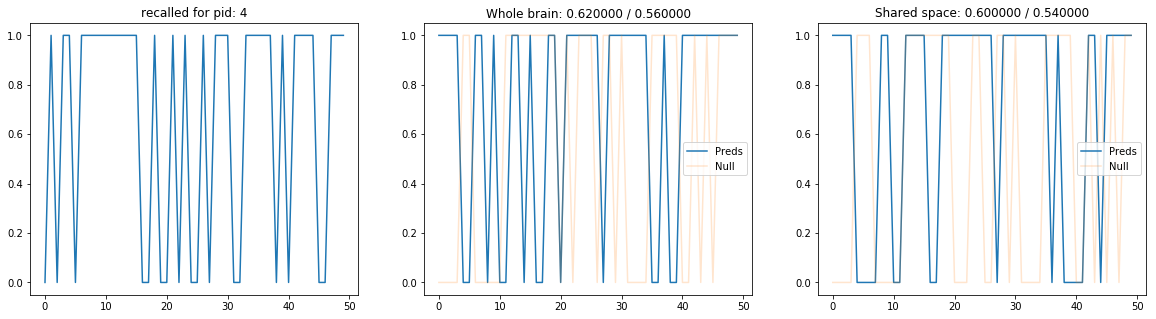

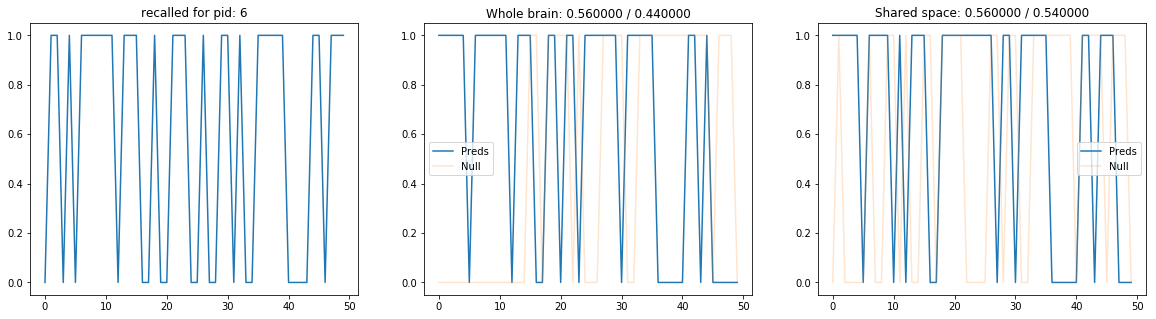

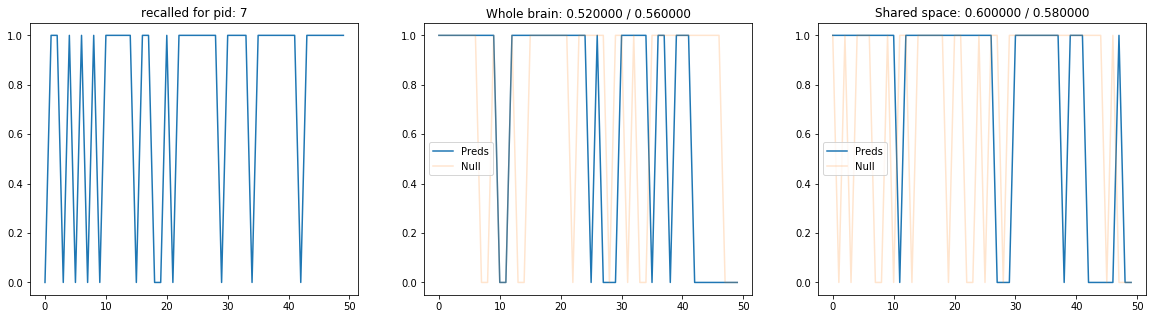

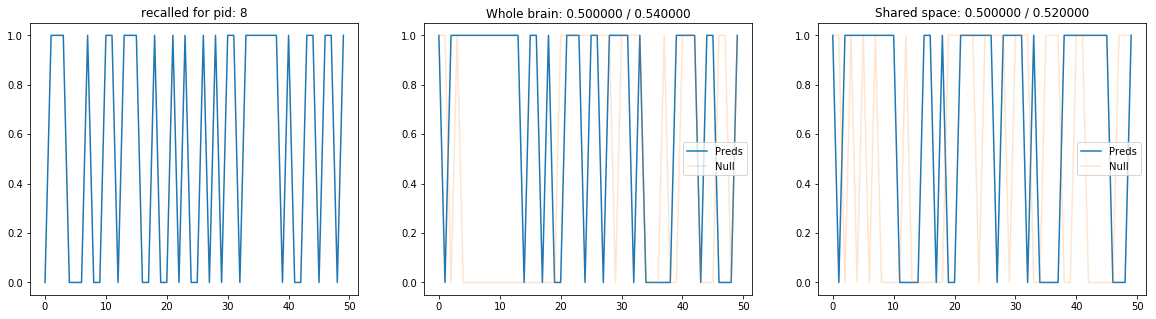

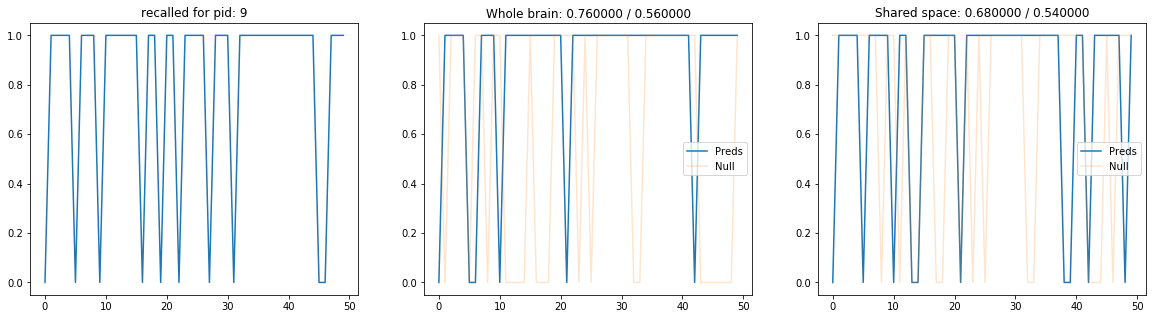

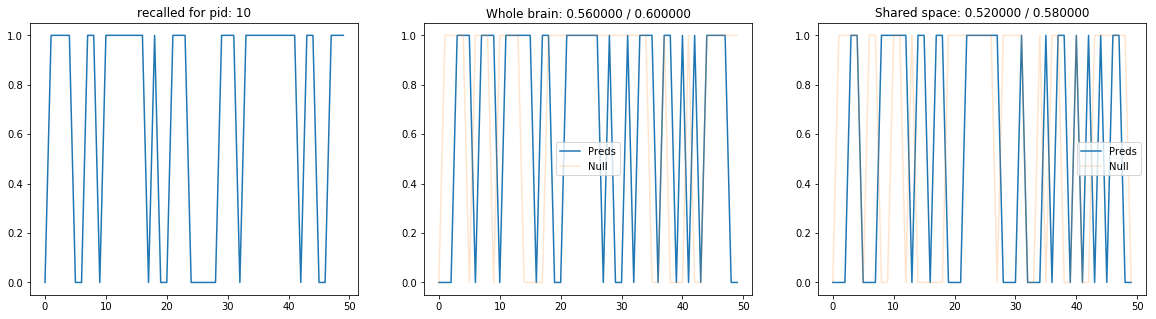

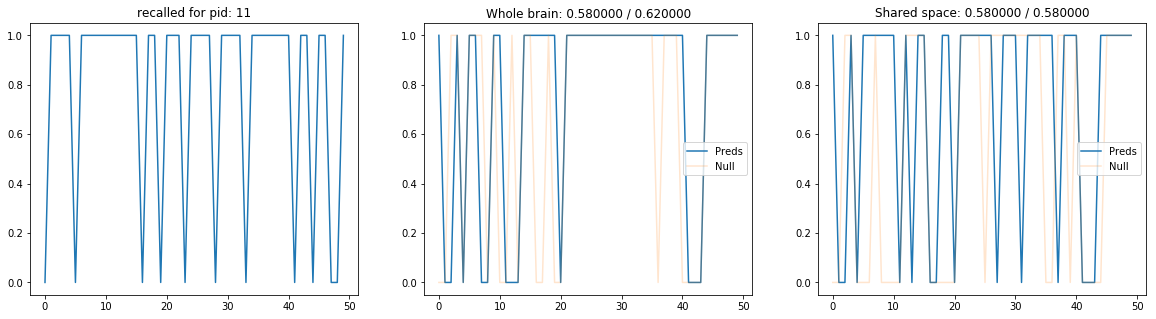

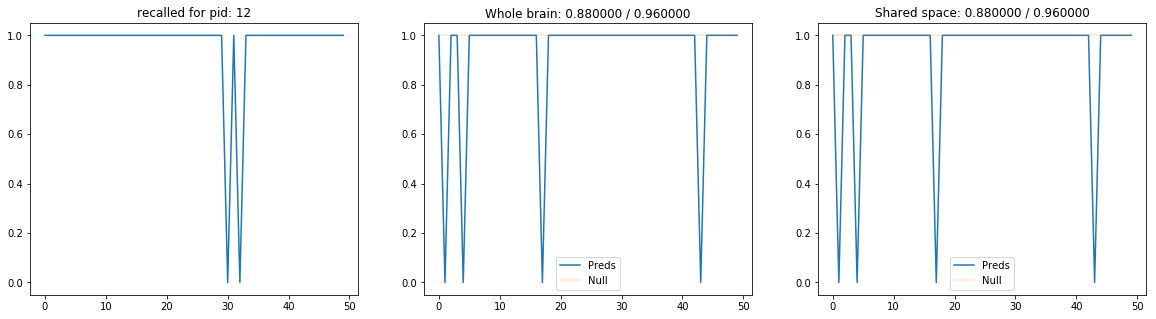

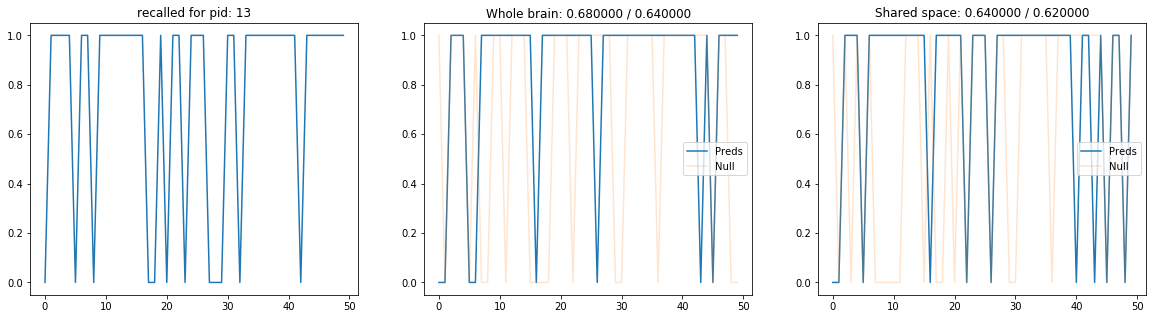

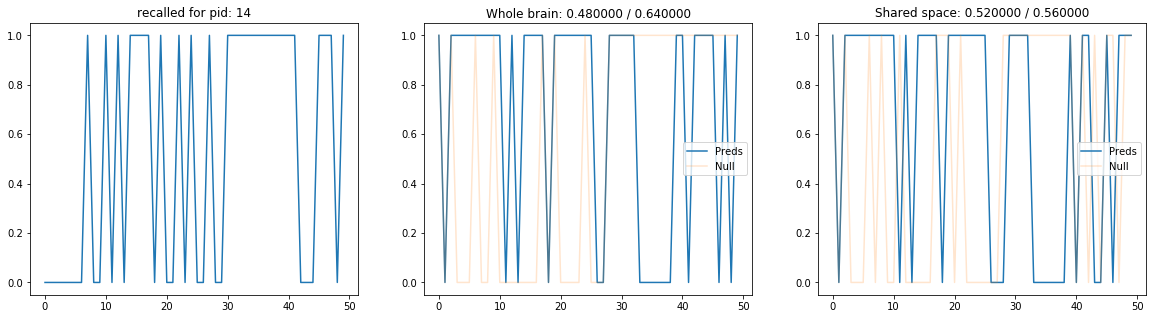

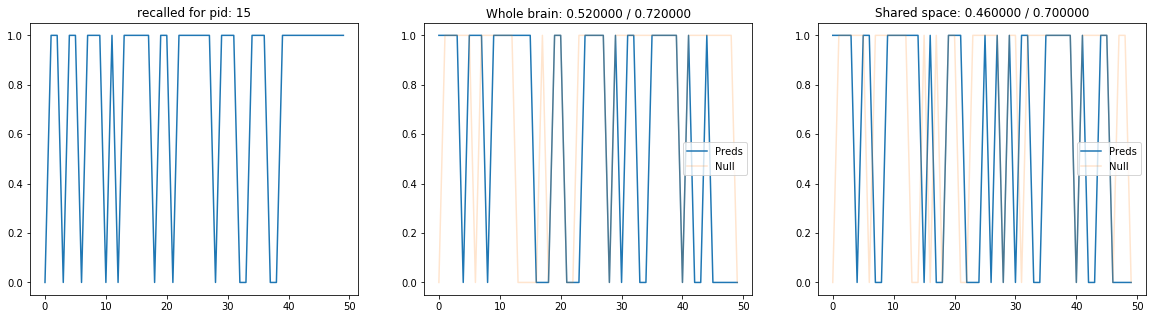

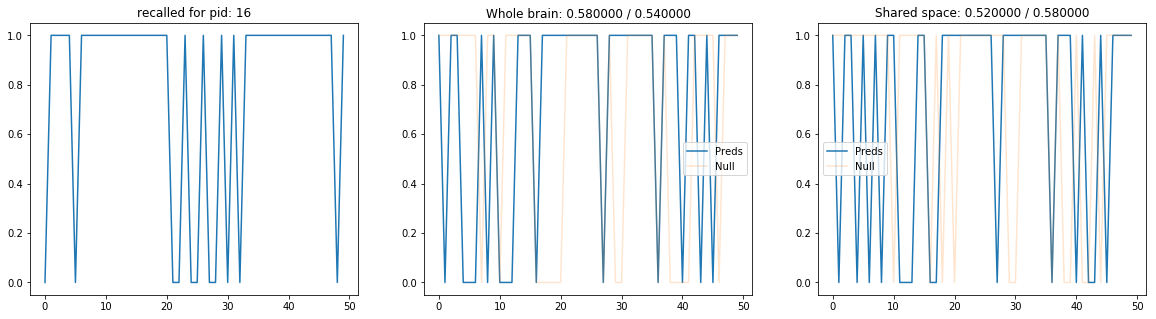

In [14]:
wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []
for pid in range(n):
    fig = plt.figure(figsize= [20, 5])
    nully = np.random.choice(np.ravel(recalled[pid]), nScenes, replace = False)
    preds_wb = predSbjRecall(movie_data_sc[pid], recalled[pid], svm.SVC(kernel="linear"))
    wb_null = predSbjRecall(movie_data_sc[pid], nully, svm.SVC(kernel="linear"))
    preds_shared = predSbjRecall(shared_data_sc[pid], recalled[pid], svm.SVC(kernel="linear"))
    shared_null = predSbjRecall(shared_data_sc[pid], nully, svm.SVC(kernel="linear"))
    
    wb_accs.append(np.mean(preds_wb == recalled[pid]))
    wb_null_accs.append(np.mean(wb_null == recalled[pid]))
    shared_accs.append(np.mean(preds_shared == recalled[pid]))
    shared_null_accs.append(np.mean(shared_null == recalled[pid]))
    
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(recalled[pid])
    plt.title("recalled for pid: " + str(pid))
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(preds_wb)
    plt.plot(wb_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Whole brain: %f / %f" % (wb_accs[pid], wb_null_accs[pid]))
    ax = fig.add_subplot(1, 3, 3)
    plt.plot(preds_shared)
    plt.plot(shared_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Shared space: %f / %f" % (shared_accs[pid], shared_null_accs[pid]))

In [15]:
np.mean(wb_accs), np.mean(wb_null_accs), np.mean(shared_accs), np.mean(shared_null_accs)
# on average, null does better

(0.5882352941176471,
 0.6011764705882352,
 0.5658823529411764,
 0.5976470588235294)

In [ ]:
# trying with TR-based instead of scene-based data, K fold  
wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []


# for a single participant, predict the recall for each scene using LOOCV on the others 
# given an X matrix of time x features (each time is a single observation)
def predSbjRecall_kfold(X, y, classifier = svm.SVC(kernel = "linear"), k = 2):
    results = []
    skf = StratifiedKFold(n_splits = k)
    skf.get_n_splits(X, y)
    for train_idx, test_idx in skf.split(X, y):
        trainx = X[train_idx, :]
        testx = X[test_idx, :]
        
        trainy = y[train_idx]
        testy = y[test_idx]
        
        classifier.fit(trainx, trainy)
        preds = classifier.predict(testx)
        results.append(np.mean(preds == testy))
    return results


for pid in np.random.choice(n, 3, replace = False):
    print("Working on PID %d" % pid)
    start = time.time()
    
    y = np.ravel(get_recall_labels(pid))
    nully = np.ravel(np.random.choice(y, len(y), replace = False))
    preds_wb = 0#predSbjRecall_kfold(movie_data[pid].T, y, svm.SVC(kernel="linear"))
    wb_null = 0#predSbjRecall_kfold(movie_data[pid].T, nully, svm.SVC(kernel="linear"))
    preds_shared = predSbjRecall_kfold(shared_data[pid].T, y, svm.SVC(kernel="linear"))
    shared_null = predSbjRecall_kfold(shared_data[pid].T, nully, svm.SVC(kernel="linear"))
    print("Finished preds in %f time" % (time.time() - start))
    
    wb_accs.append(preds_wb)
    wb_null_accs.append(wb_null)
    shared_accs.append(preds_shared)
    shared_null_accs.append(shared_null)

In [ ]:
shared_accs, shared_null_accs

In [ ]:
stats.ttest_rel(shared_accs, shared_null_accs)

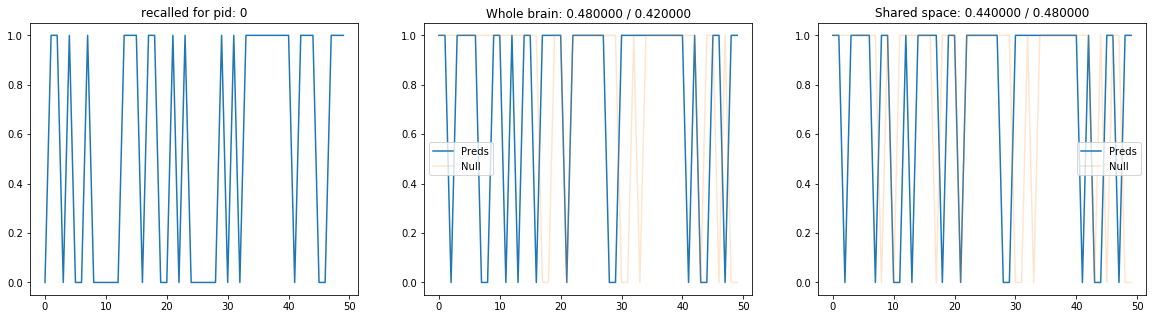

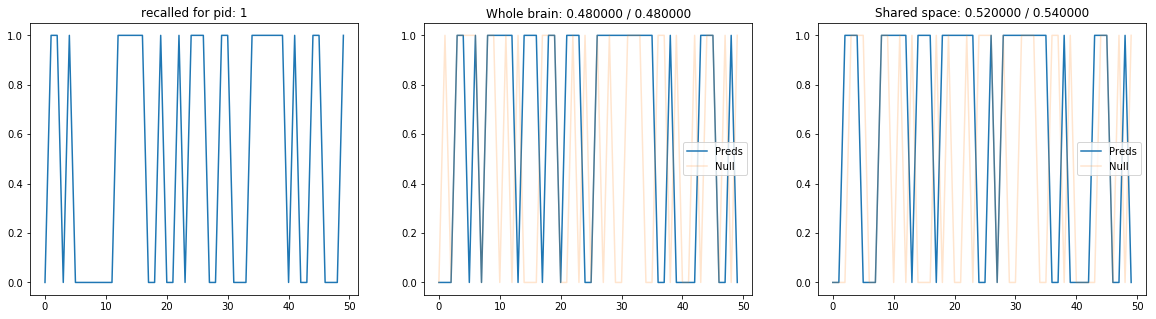

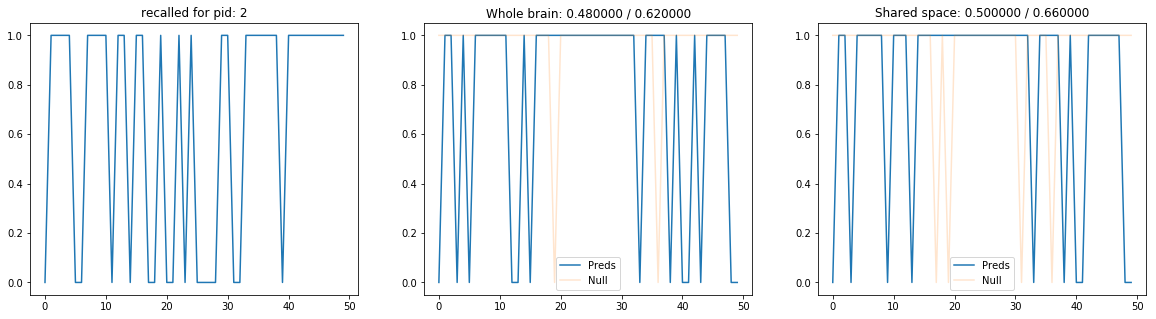

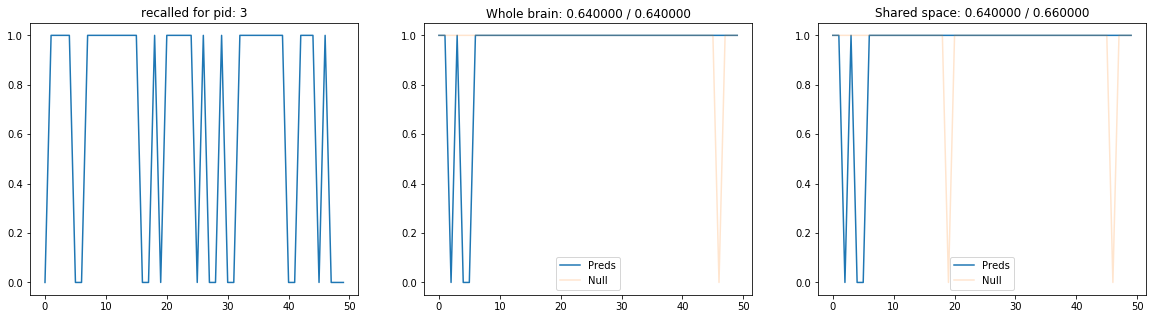

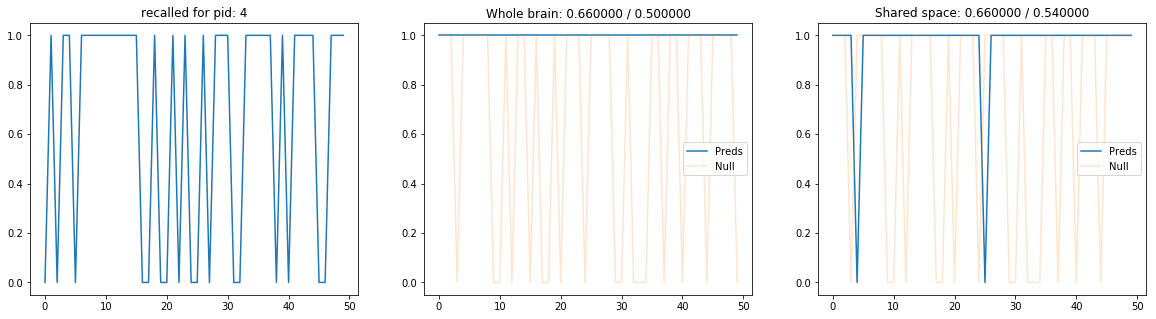

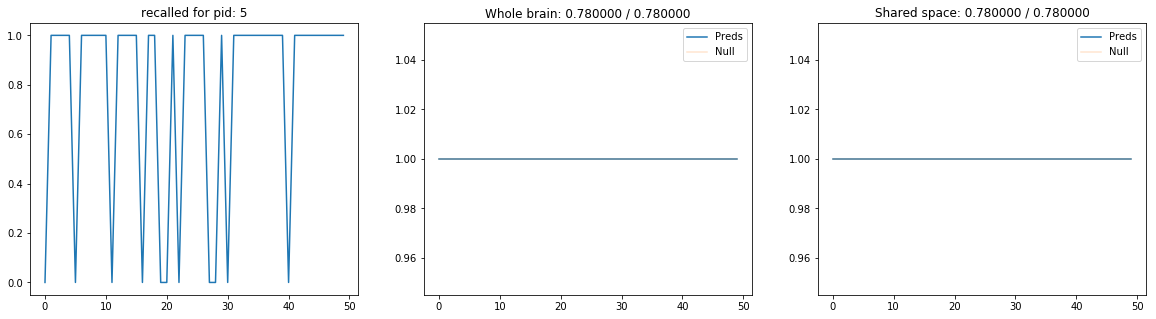

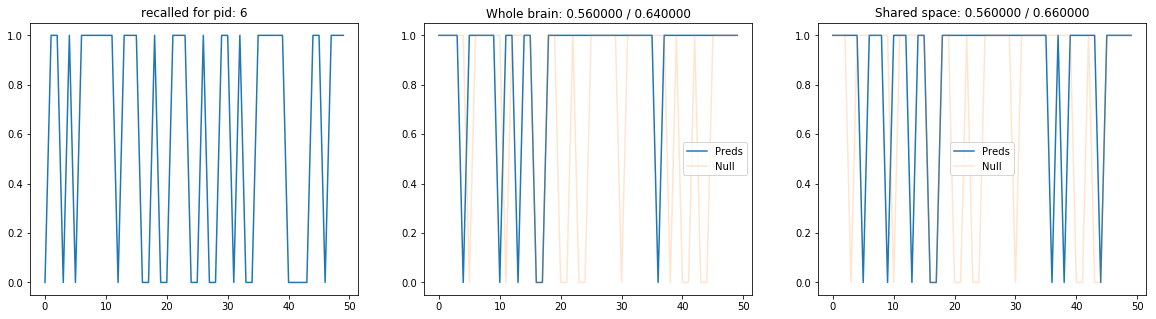

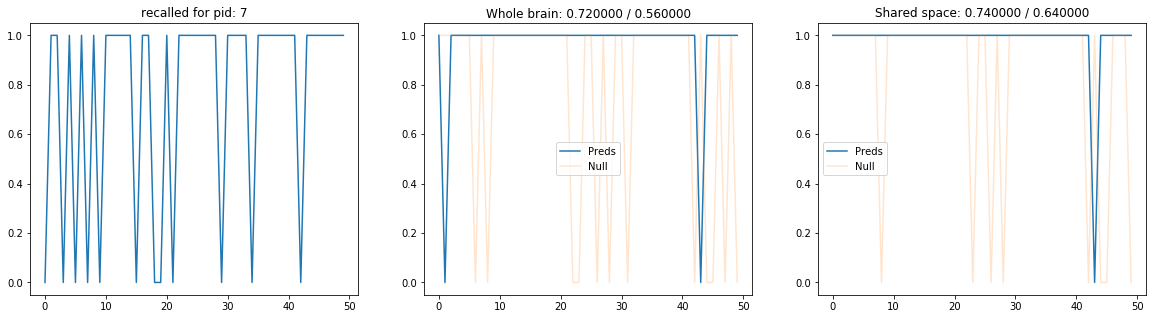

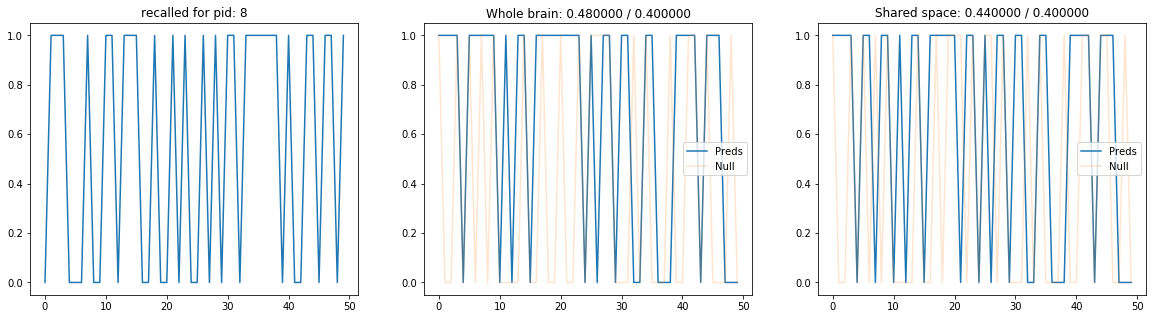

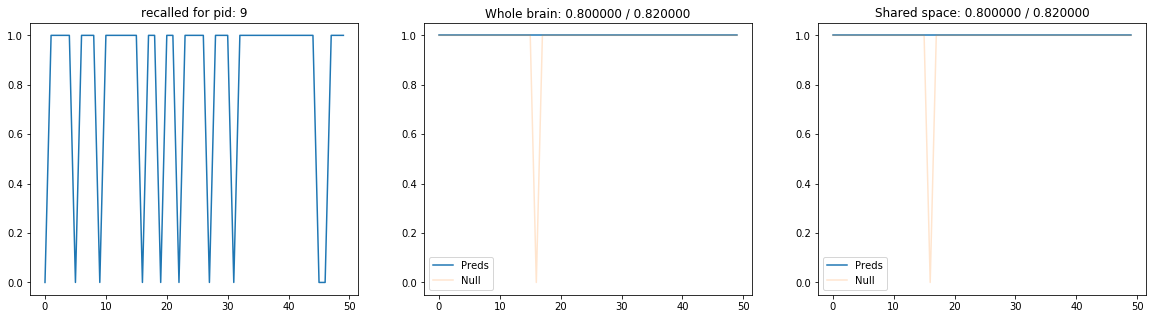

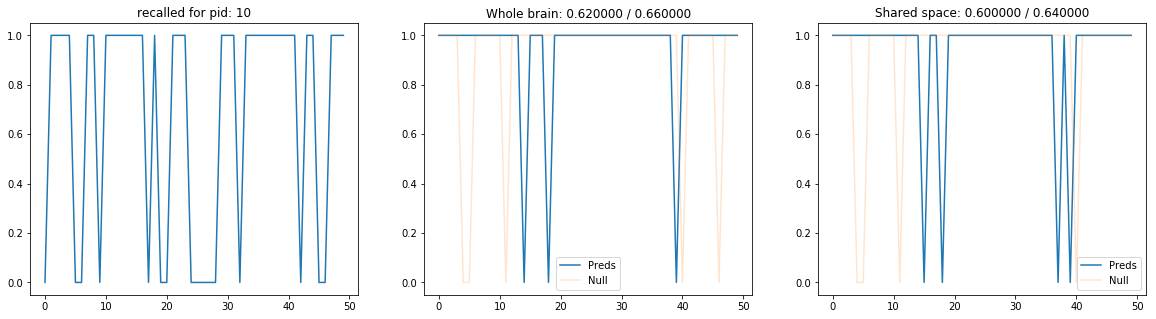

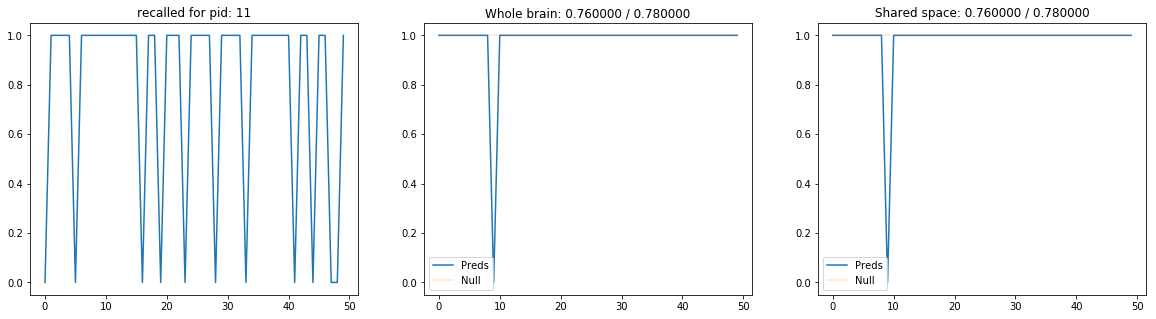

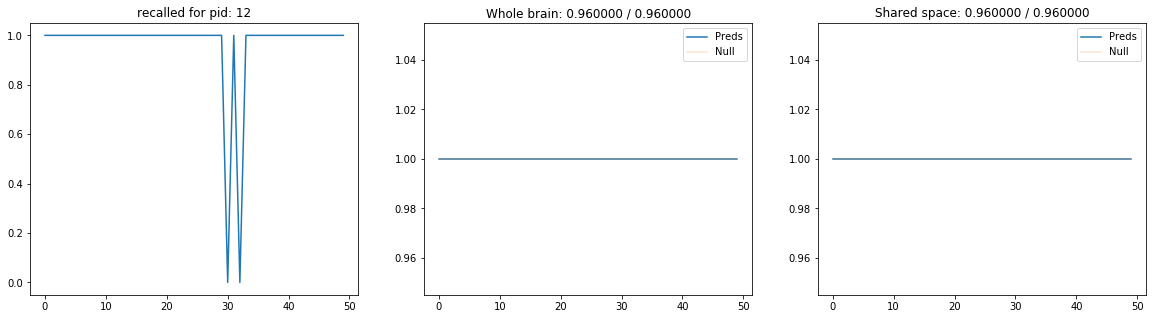

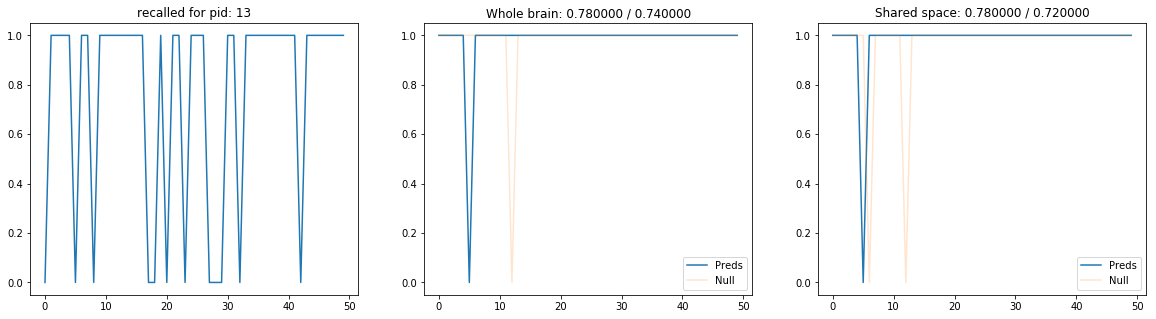

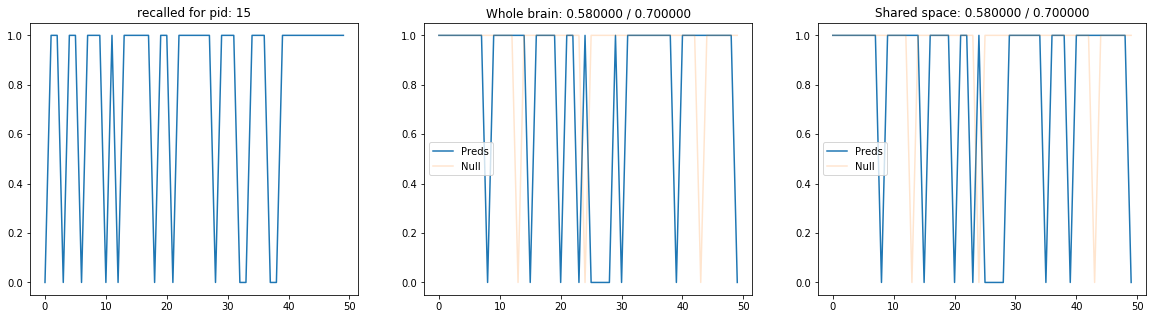

In [13]:
# With KNN
wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []
for pid in range(n):
    fig = plt.figure(figsize= [20, 5])
    nully = np.random.choice(np.ravel(recalled[pid]), nScenes, replace = False)
    preds_wb = predSbjRecall(movie_data_sc[pid], recalled[pid], KNeighborsClassifier())
    wb_null = predSbjRecall(movie_data_sc[pid], nully, KNeighborsClassifier())
    preds_shared = predSbjRecall(shared_data_sc[pid], recalled[pid], KNeighborsClassifier())
    shared_null = predSbjRecall(shared_data_sc[pid], nully, KNeighborsClassifier())
    
    wb_accs.append(np.mean(preds_wb == recalled[pid]))
    wb_null_accs.append(np.mean(wb_null == recalled[pid]))
    shared_accs.append(np.mean(preds_shared == recalled[pid]))
    shared_null_accs.append(np.mean(shared_null == recalled[pid]))
    
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(recalled[pid])
    plt.title("recalled for pid: " + str(pid))
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(preds_wb)
    plt.plot(wb_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Whole brain: %f / %f" % (wb_accs[pid], wb_null_accs[pid]))
    ax = fig.add_subplot(1, 3, 3)
    plt.plot(preds_shared)
    plt.plot(shared_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Shared space: %f / %f" % (shared_accs[pid], shared_null_accs[pid]))

In [14]:
np.mean(wb_accs), np.mean(wb_null_accs), np.mean(shared_accs), np.mean(shared_null_accs)
# on average, null does worse here

(0.6470588235294118,
 0.6447058823529412,
 0.6470588235294118,
 0.6647058823529413)

In [15]:
stats.ttest_rel(wb_accs, wb_null_accs), stats.ttest_rel(shared_accs, shared_null_accs)

(Ttest_relResult(statistic=0.11857383334575056, pvalue=0.9070889122654715),
 Ttest_relResult(statistic=-0.9953109657524406, pvalue=0.3344002620968707))

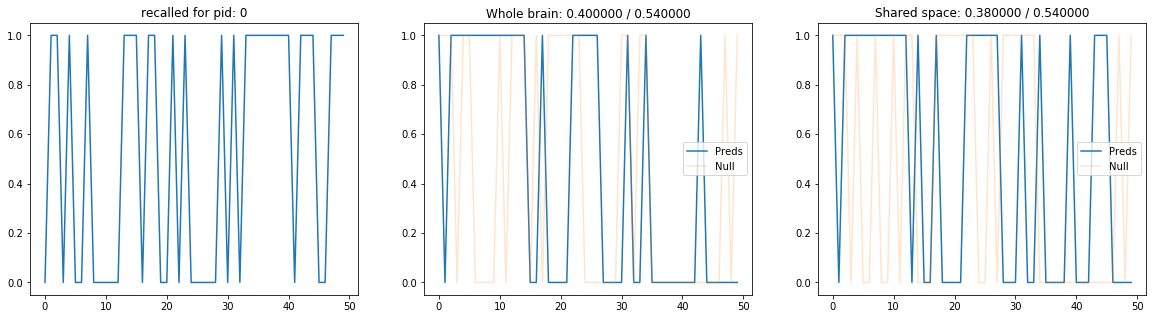

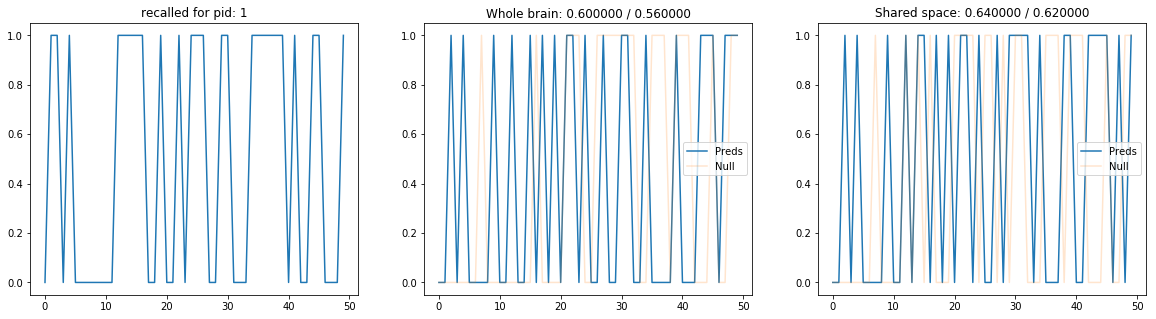

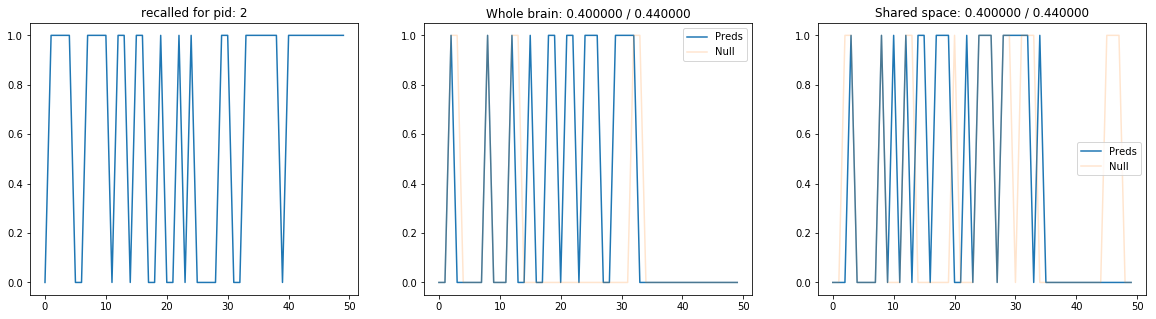

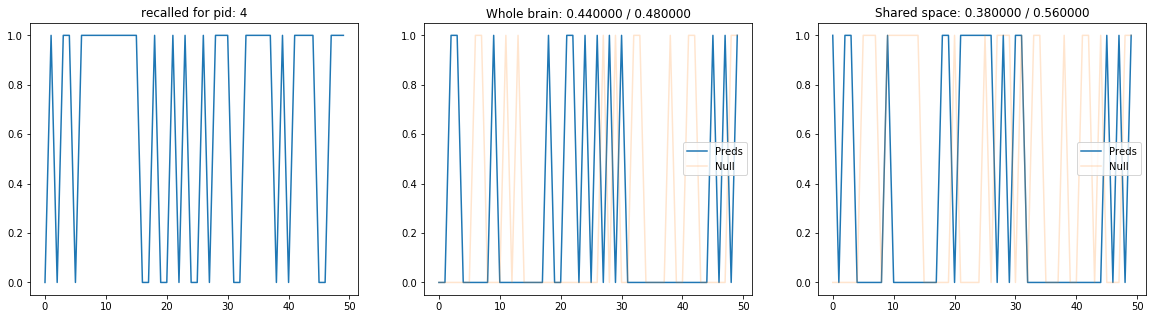

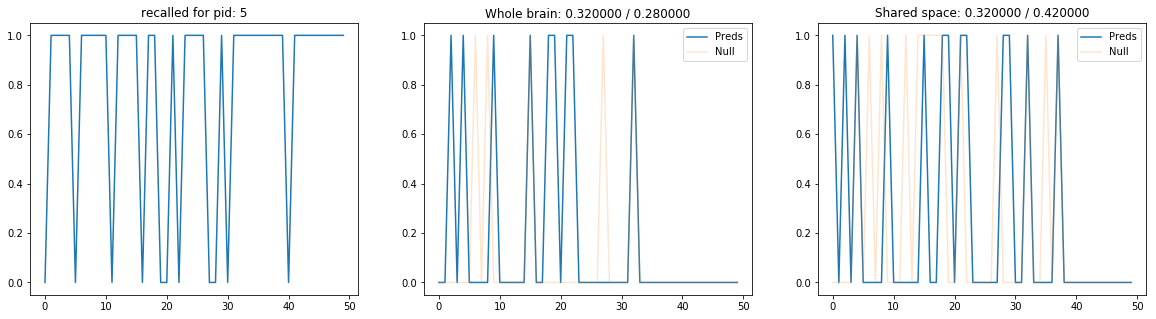

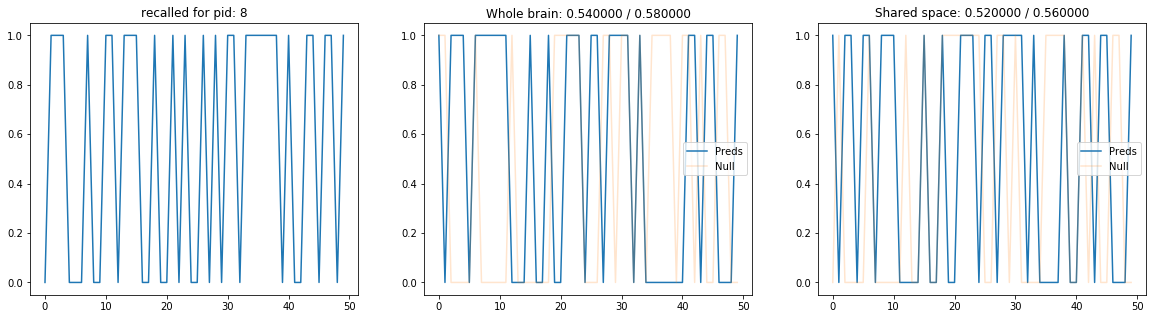

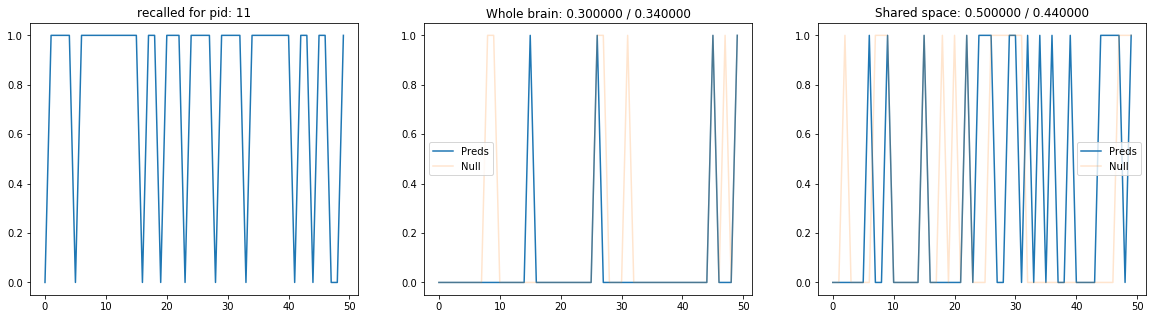

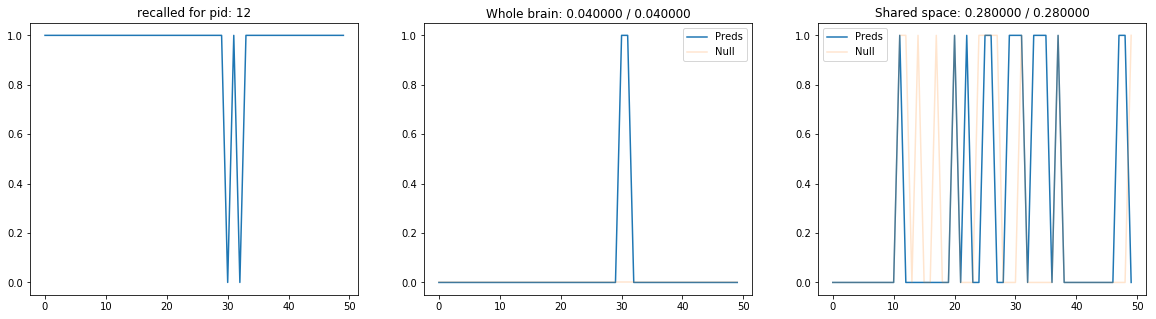

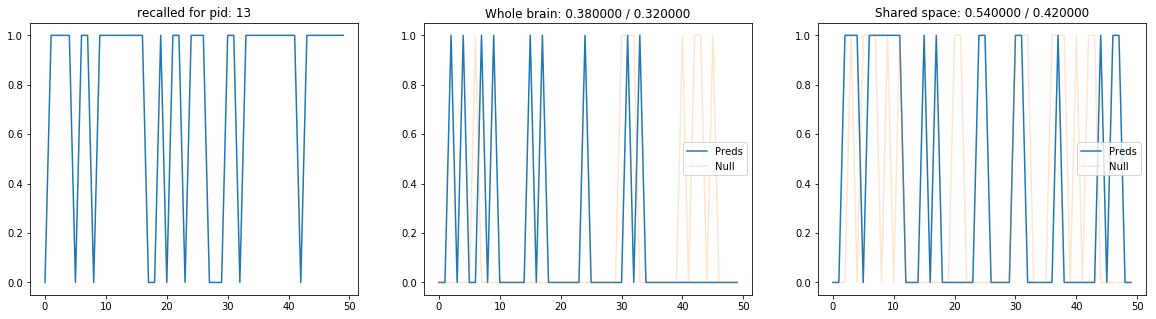

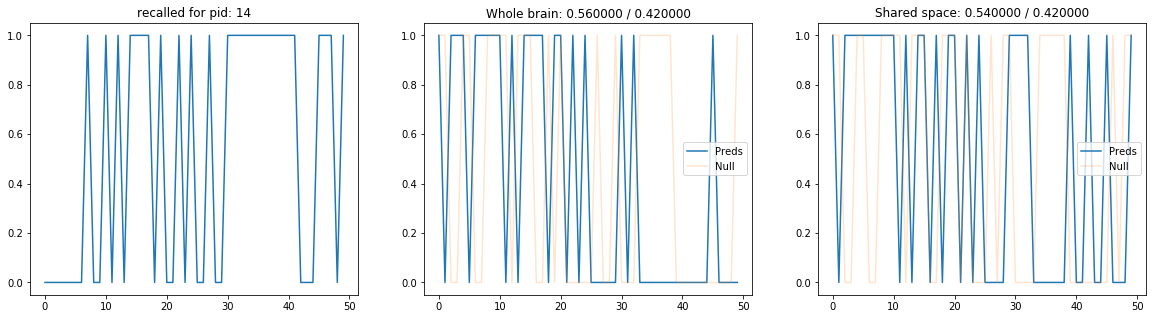

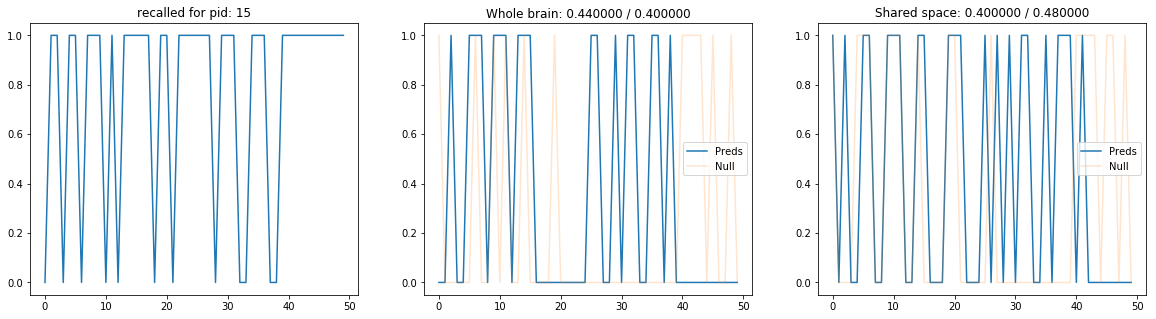

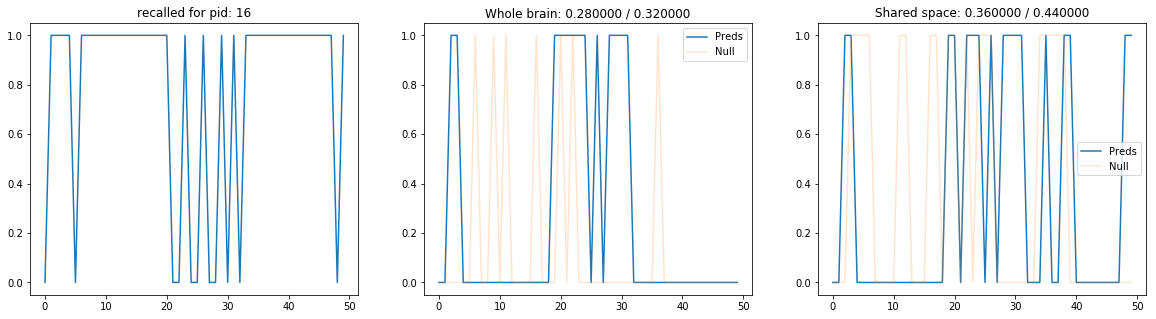

In [121]:
# With Logistic
wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []
for pid in range(n):
    fig = plt.figure(figsize= [20, 5])
    nully = np.random.choice(np.ravel(recalled[pid]), nScenes, replace = False)
    model = linear_model.LogisticRegression()
    preds_wb = predSbjRecall(movie_data_sc[pid], recalled[pid], model)
    wb_null = predSbjRecall(movie_data_sc[pid], nully, model)
    preds_shared = predSbjRecall(shared_data_sc[pid], recalled[pid], model)
    shared_null = predSbjRecall(shared_data_sc[pid], nully, model)
    
    wb_accs.append(np.mean(preds_wb == recalled[pid]))
    wb_null_accs.append(np.mean(wb_null == recalled[pid]))
    shared_accs.append(np.mean(preds_shared == recalled[pid]))
    shared_null_accs.append(np.mean(shared_null == recalled[pid]))
    
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(recalled[pid])
    plt.title("recalled for pid: " + str(pid))
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(preds_wb)
    plt.plot(wb_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Whole brain: %f / %f" % (wb_accs[pid], wb_null_accs[pid]))
    ax = fig.add_subplot(1, 3, 3)
    plt.plot(preds_shared)
    plt.plot(shared_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Shared space: %f / %f" % (shared_accs[pid], shared_null_accs[pid]))

In [122]:
np.mean(wb_accs), np.mean(wb_null_accs), np.mean(shared_accs), np.mean(shared_null_accs)

(0.3929411764705883,
 0.39647058823529413,
 0.43411764705882355,
 0.4658823529411765)

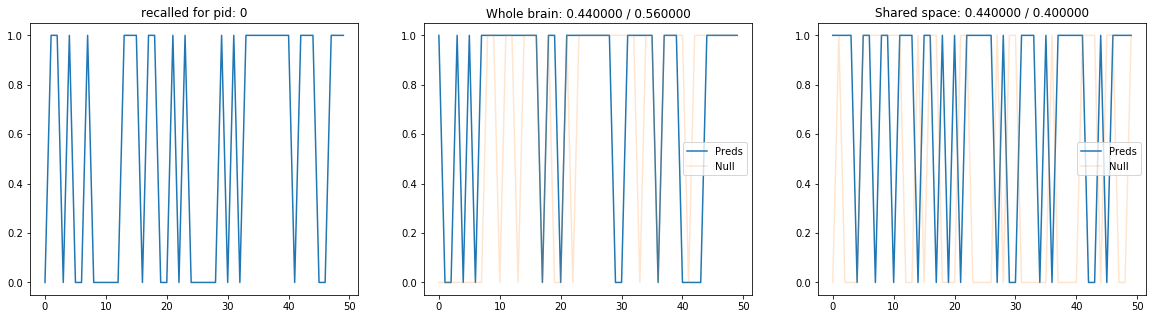

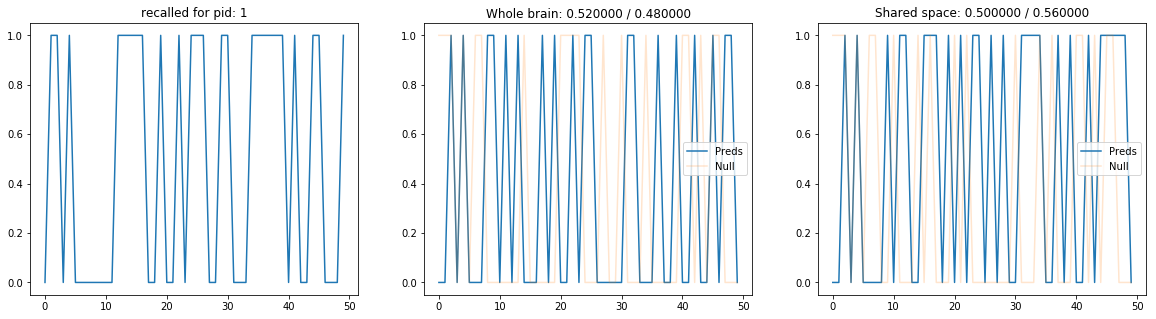

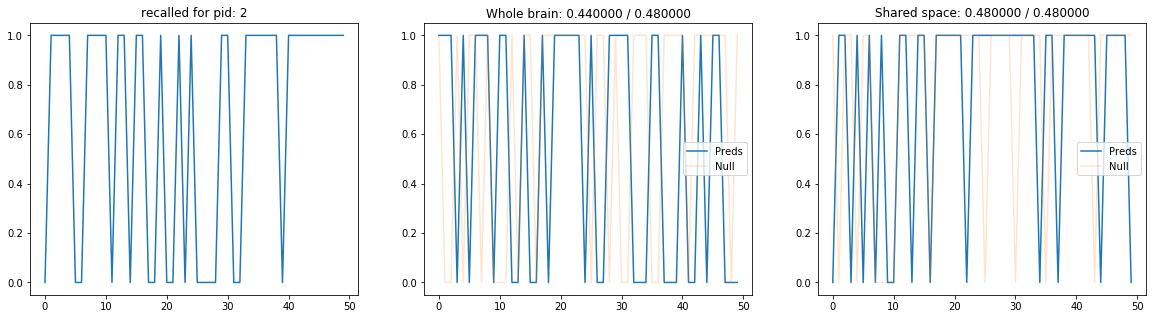

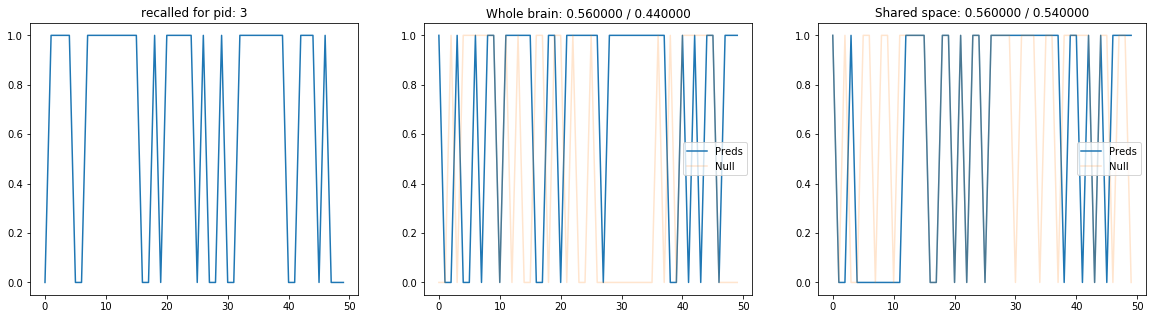

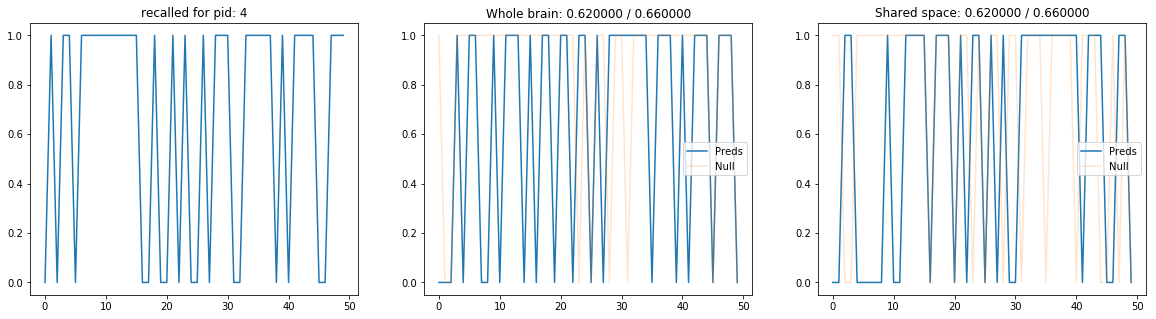

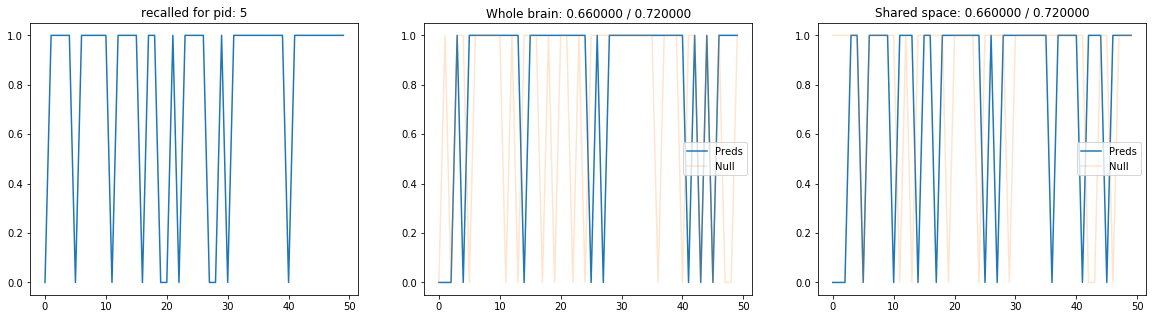

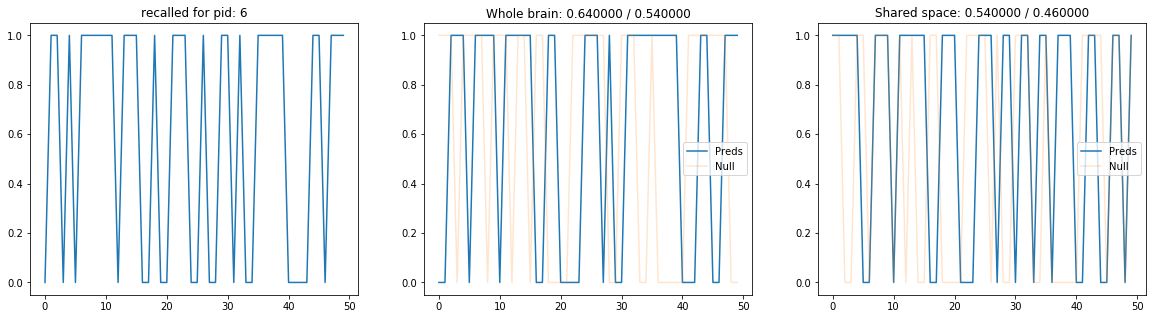

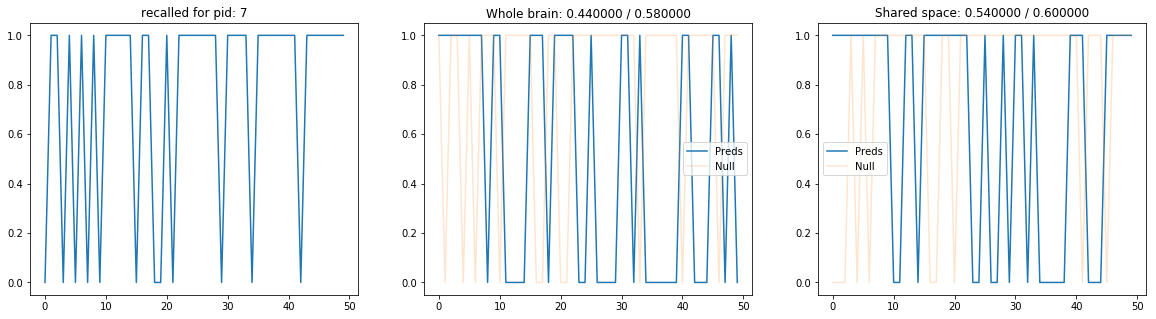

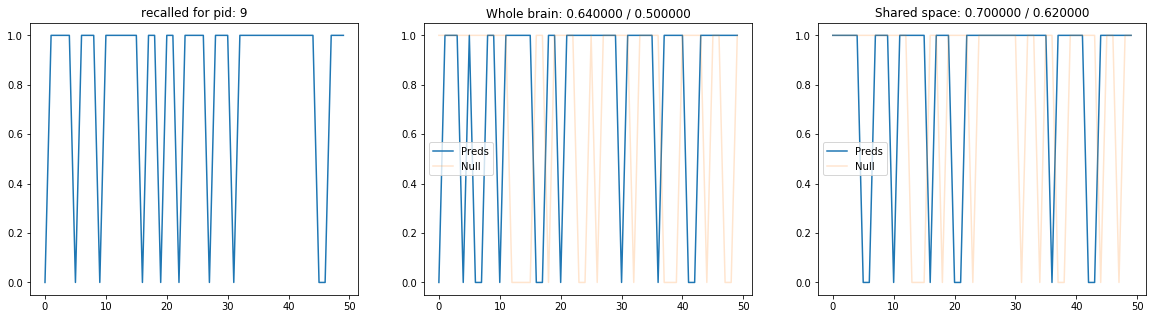

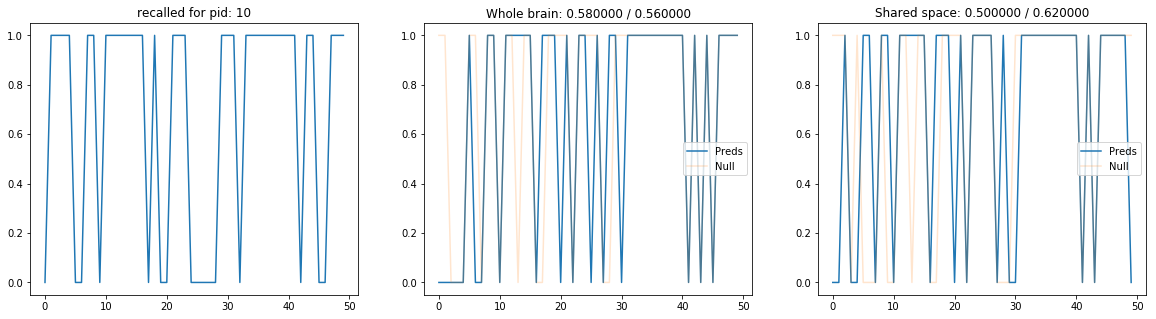

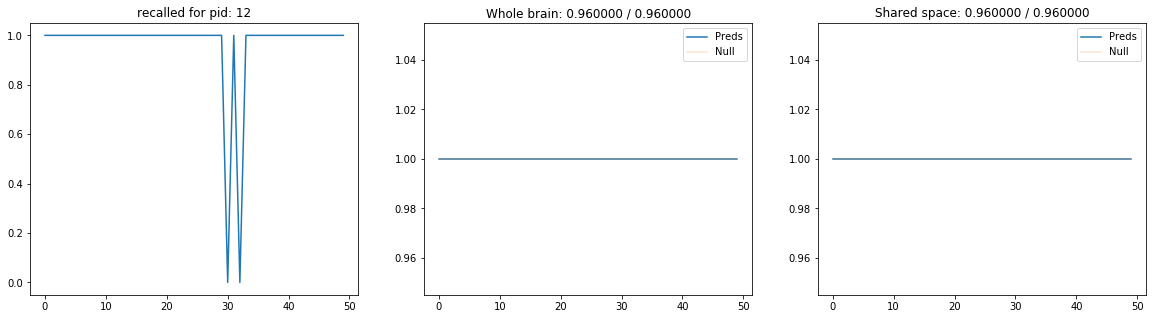

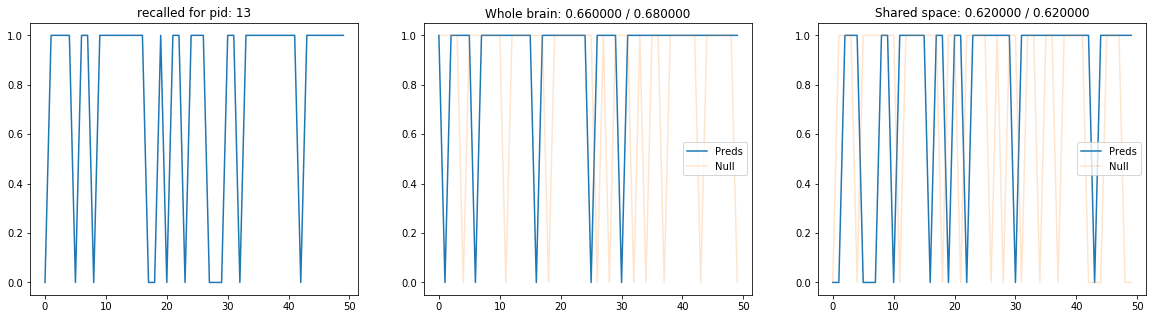

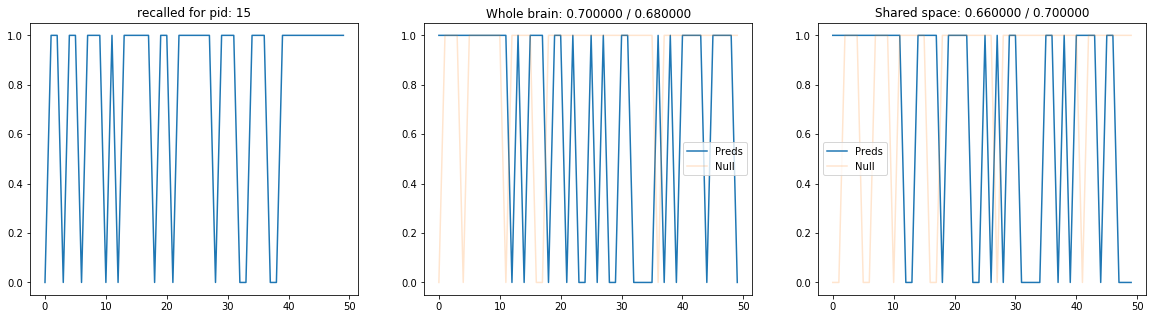

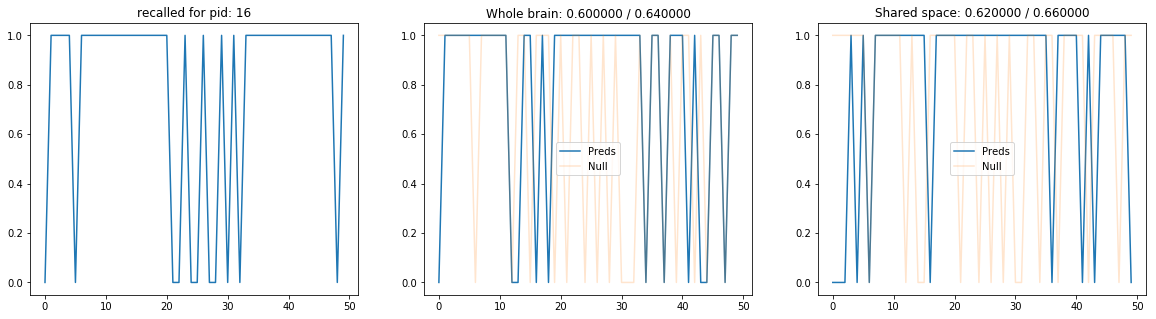

In [10]:
# With Naive Bayes

wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []
for pid in range(n):
    fig = plt.figure(figsize= [20, 5])
    nully = np.random.choice(np.ravel(recalled[pid]), nScenes, replace = False)
    model = GaussianNB()
    preds_wb = predSbjRecall(movie_data_sc[pid], recalled[pid], model)
    wb_null = predSbjRecall(movie_data_sc[pid], nully, model)
    preds_shared = predSbjRecall(shared_data_sc[pid], recalled[pid], model)
    shared_null = predSbjRecall(shared_data_sc[pid], nully, model)
    
    wb_accs.append(np.mean(preds_wb == recalled[pid]))
    wb_null_accs.append(np.mean(wb_null == recalled[pid]))
    shared_accs.append(np.mean(preds_shared == recalled[pid]))
    shared_null_accs.append(np.mean(shared_null == recalled[pid]))
    
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(recalled[pid])
    plt.title("recalled for pid: " + str(pid))
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(preds_wb)
    plt.plot(wb_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Whole brain: %f / %f" % (wb_accs[pid], wb_null_accs[pid]))
    ax = fig.add_subplot(1, 3, 3)
    plt.plot(preds_shared)
    plt.plot(shared_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Shared space: %f / %f" % (shared_accs[pid], shared_null_accs[pid]))

In [11]:
np.mean(wb_accs), np.mean(wb_null_accs), np.mean(shared_accs), np.mean(shared_null_accs)

(0.6070588235294118,
 0.5882352941176471,
 0.6141176470588235,
 0.5929411764705882)

In [12]:
stats.ttest_rel(wb_accs, wb_null_accs), stats.ttest_rel(shared_accs, shared_null_accs)

(Ttest_relResult(statistic=0.6637204562558578, pvalue=0.5163197633435102),
 Ttest_relResult(statistic=0.7466855132878406, pvalue=0.46608470611603015))

In [6]:
from sklearn.ensemble import AdaBoostClassifier 

Finished participant 0 in 962.494958
Finished participant 1 in 963.227751
Finished participant 2 in 974.240897
Finished participant 3 in 1124.213346
Finished participant 4 in 1221.252972
Finished participant 5 in 732.404618
Finished participant 6 in 755.006472
Finished participant 7 in 648.322921
Finished participant 8 in 610.044361
Finished participant 9 in 608.539920
Finished participant 10 in 624.620556
Finished participant 11 in 609.742981
Finished participant 12 in 302.951965
Finished participant 13 in 604.801041
Finished participant 14 in 604.167228
Finished participant 15 in 619.498165
Finished participant 16 in 622.648885


(0.636470588235294, 0.6341176470588233, 0.6211764705882352, 0.6235294117647059)

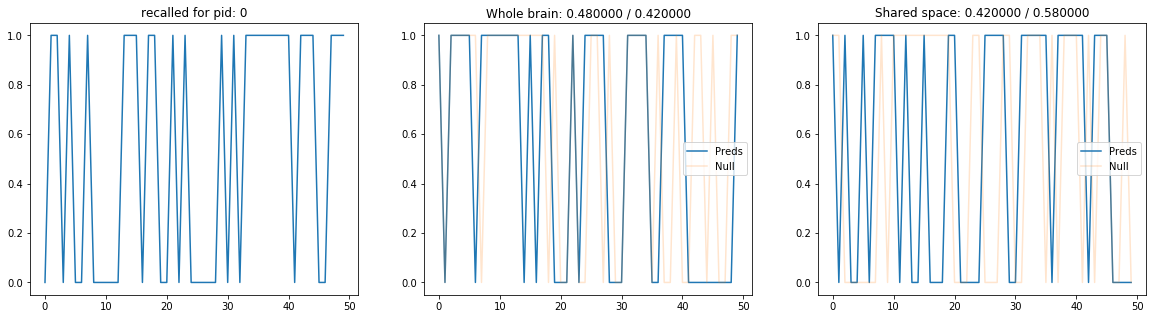

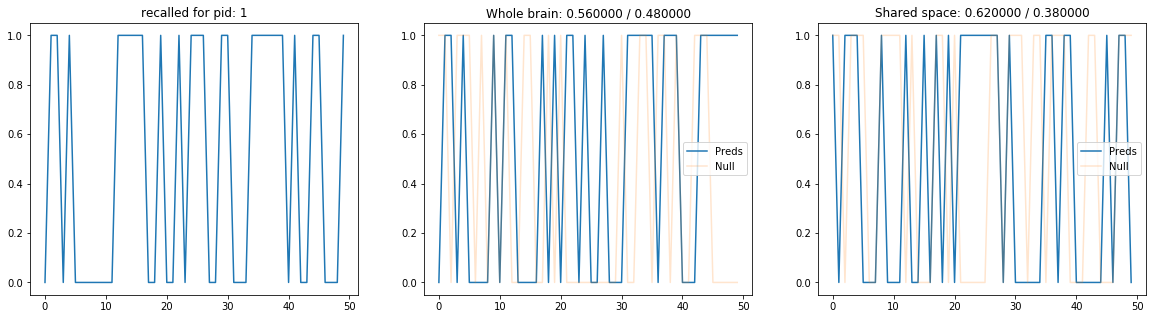

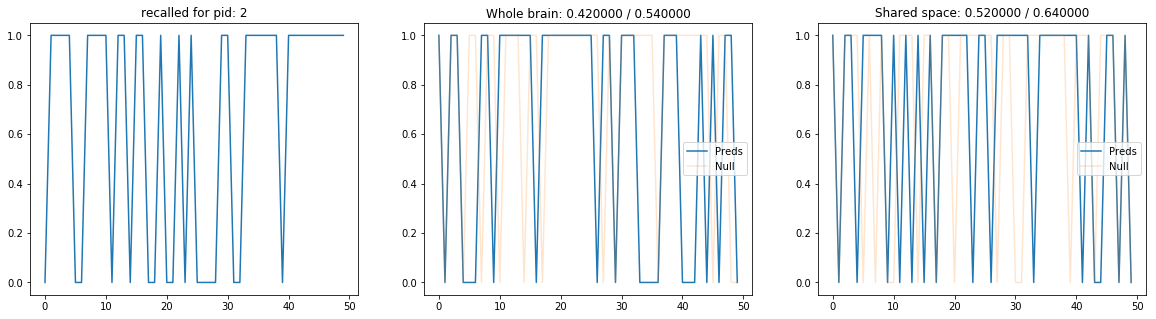

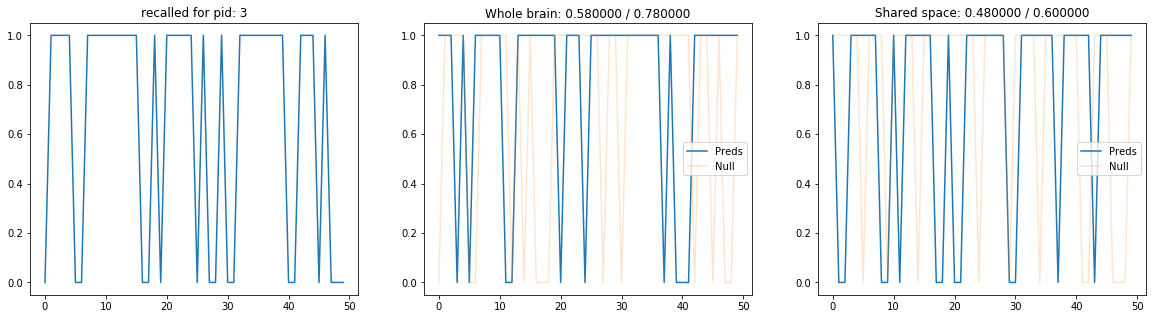

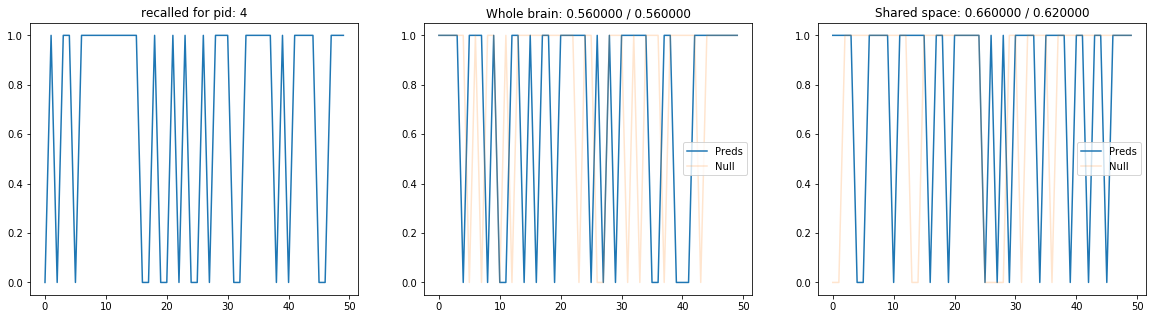

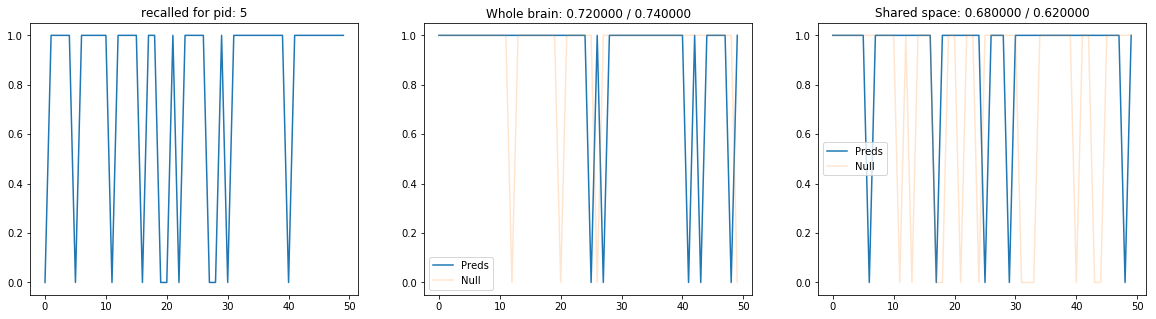

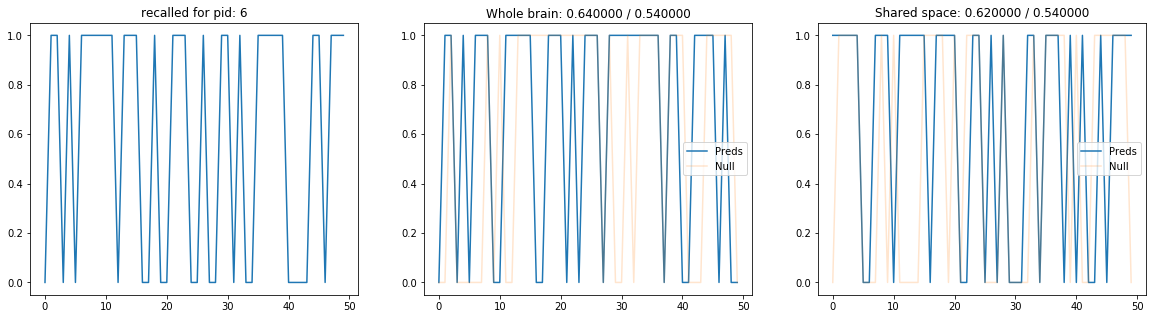

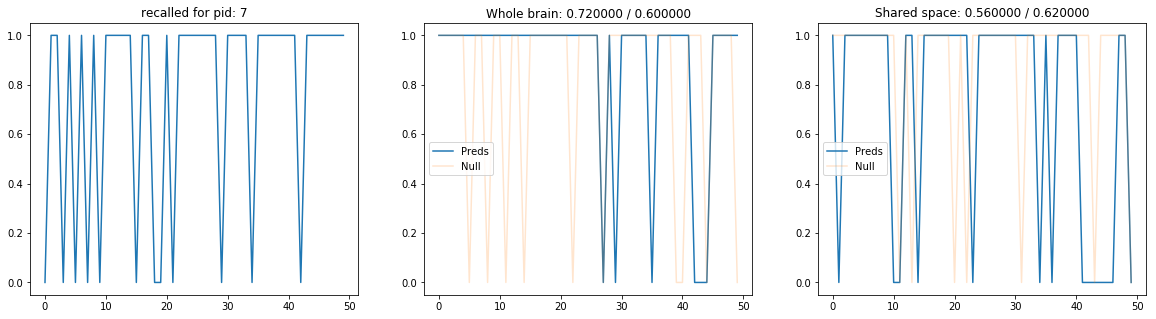

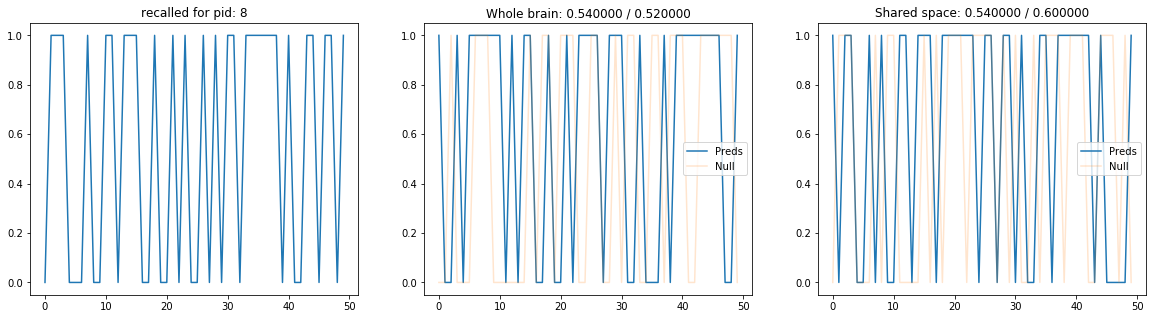

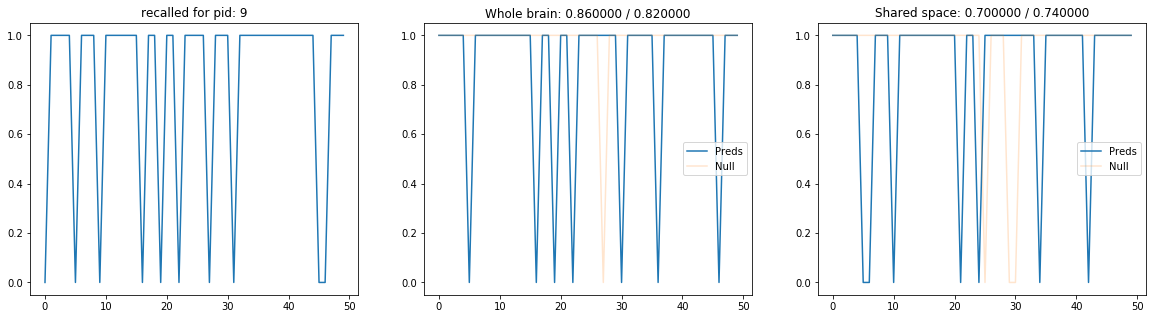

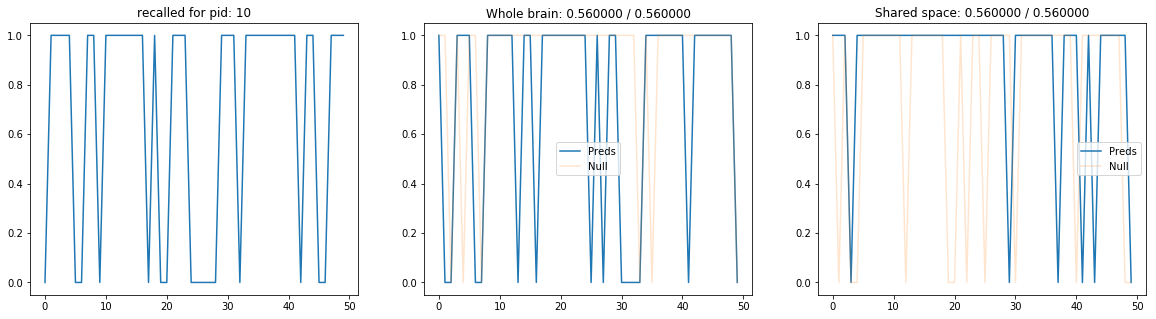

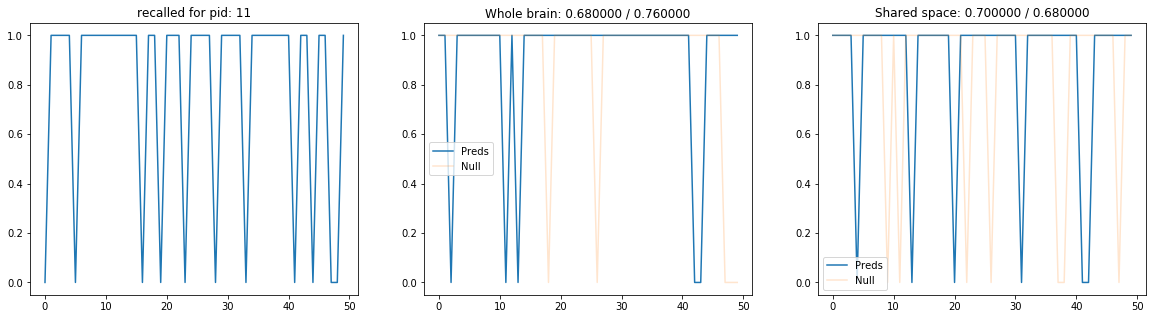

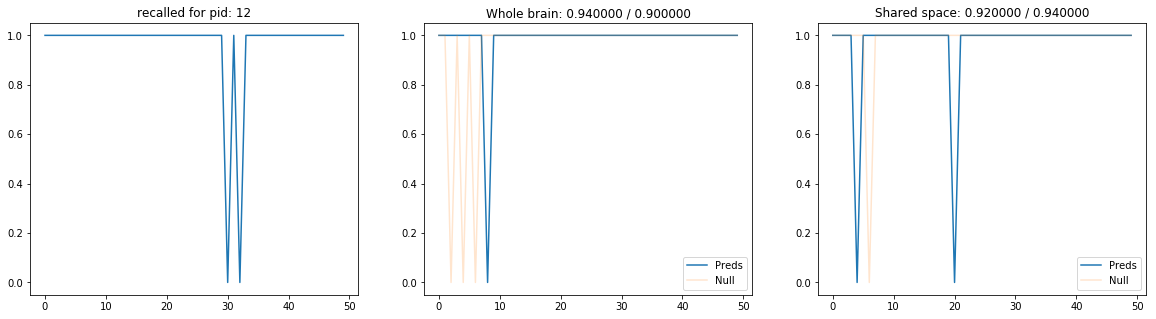

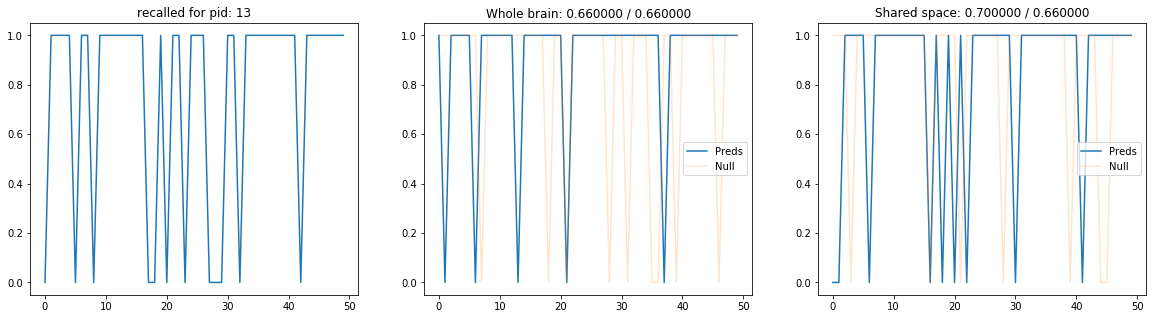

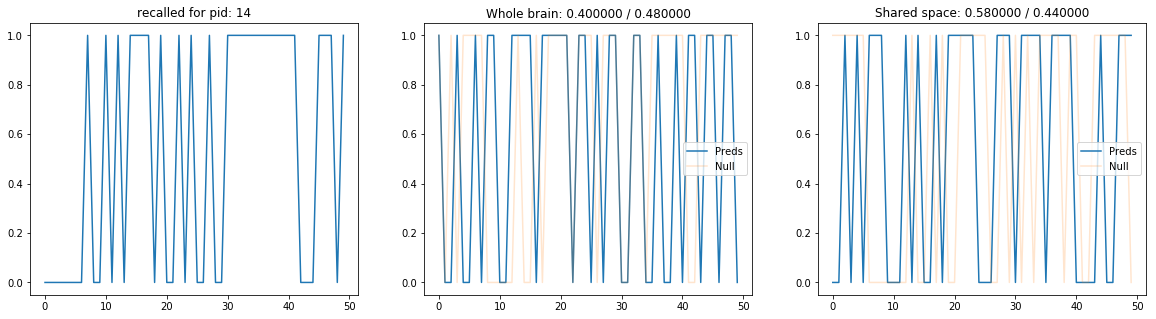

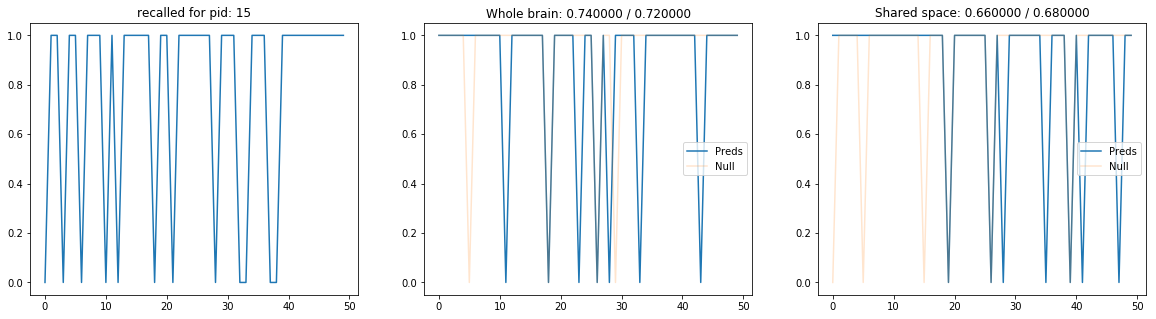

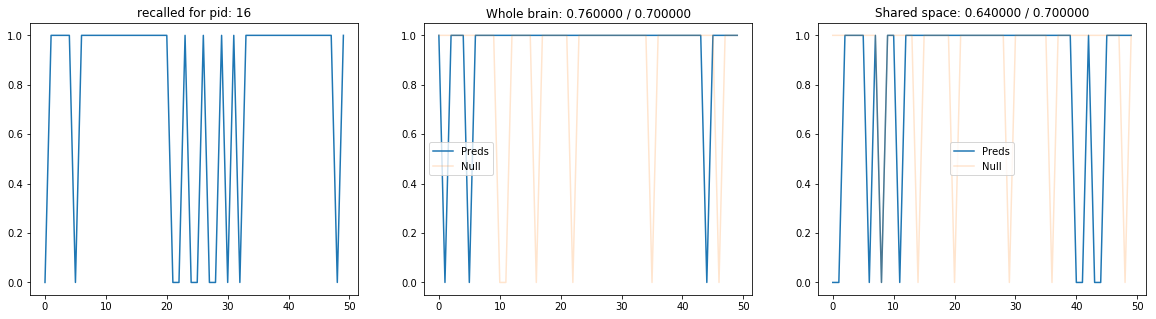

In [7]:
wb_accs = []
wb_null_accs = []
shared_accs = []
shared_null_accs = []
for pid in range(n):
    start = time.time()
    fig = plt.figure(figsize= [20, 5])
    nully = np.random.choice(np.ravel(recalled[pid]), nScenes, replace = False)
    model = AdaBoostClassifier()
    preds_wb = predSbjRecall(movie_data_sc[pid], recalled[pid], model)
    wb_null = predSbjRecall(movie_data_sc[pid], nully, model)
    preds_shared = predSbjRecall(shared_data_sc[pid], recalled[pid], model)
    shared_null = predSbjRecall(shared_data_sc[pid], nully, model)
    
    wb_accs.append(np.mean(preds_wb == recalled[pid]))
    wb_null_accs.append(np.mean(wb_null == recalled[pid]))
    shared_accs.append(np.mean(preds_shared == recalled[pid]))
    shared_null_accs.append(np.mean(shared_null == recalled[pid]))
    
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(recalled[pid])
    plt.title("recalled for pid: " + str(pid))
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(preds_wb)
    plt.plot(wb_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Whole brain: %f / %f" % (wb_accs[pid], wb_null_accs[pid]))
    ax = fig.add_subplot(1, 3, 3)
    plt.plot(preds_shared)
    plt.plot(shared_null, alpha = 0.2)
    plt.legend(["Preds", "Null"])
    plt.title("Shared space: %f / %f" % (shared_accs[pid], shared_null_accs[pid]))
    print("Finished participant %d in %f" % (pid, time.time() - start))
    
np.mean(wb_accs), np.mean(wb_null_accs), np.mean(shared_accs), np.mean(shared_null_accs)

In [8]:
np.mean(preds_wb == recalled[pid]), np.mean(preds_shared == recalled[pid])

(0.76, 0.64)

In [9]:
np.mean(wb_null == recalled[pid]), np.mean(shared_null == recalled[pid])

(0.7, 0.7)